<font size="3"> Here I show how to create a first names dataset by gender/country based on the Facebook data and I give some examples of how it can used.

In [1]:
from glob import glob
import io
import re
import zipfile
import rarfile
import os 
from string import punctuation, ascii_letters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def islatin(string):
    try:
        a = re.search("[A-Za-z]+",string.replace(" ","")).group(0)
        if len(a) == len(string.replace(" ","")):
            isok= 1
        else:
            isok= 2
    except:
        isok = 0
    return isok

#dictionnary mapping non ascii to ascii characters
caract_mapping = pd.read_html('https://docs.oracle.com/cd/E29584_01/webhelp/mdex_basicDev/src/rbdv_chars_mapping.html')
carac_dict = pd.DataFrame(np.concatenate([caract_mapping[i].iloc[:,[1,2]].values for i in (0,1)])).set_index(0).to_dict('dict')[1]

def name_cleaner(name):
    clean = ""
    for letter in name:
        if (letter.lower() in ascii_letters) or (letter.lower() in """ ''`'-  """):
            clean += letter
        elif letter in punctuation:
            return 'error'
        elif letter in carac_dict.keys():
            clean += carac_dict[letter]
        else:
            return 'error'
            
    return clean


# Building the dataset

In [2]:
files = glob("../data/first_names/fb_first_names/*_first_names.csv")
df_list = []
for file in files :
    country = file.replace("_first_names.csv","").replace("../data/first_names/fb_first_names/","")
    df = pd.read_csv(file)
    df.columns = ['name',"gender","count"]
    raw_len = len(df)
    df = df[df["count"] > 2]
    df["country"] = country
    cleaned_len = len(df)
    ratio = round((cleaned_len/raw_len)*100,1)
    
    print(country,", ", raw_len," records, keeping ", cleaned_len," : ", str(ratio),"%")
    df_list.append(df)
    
df = pd.concat(df_list)
df = df[df["gender"].isin(["male","female"])]

ok = df["name"].apply(islatin)
df= df[ok != 0]

df = df.groupby(["country","name","gender"])["count"].sum()
df = df.unstack().fillna(0)
df = df.reset_index()
df

Germany ,  391032  records, keeping  62953  :  16.1 %
Maldives ,  31919  records, keeping  3811  :  11.9 %
Bahrain ,  294556  records, keeping  42272  :  14.4 %
Libya ,  753910  records, keeping  89172  :  11.8 %
Tunisia ,  623253  records, keeping  86583  :  13.9 %
Iceland ,  7597  records, keeping  1256  :  16.5 %
iran ,  202927  records, keeping  33839  :  16.7 %
Macao ,  119825  records, keeping  17196  :  14.4 %
Norway ,  79486  records, keeping  11749  :  14.8 %
Moldova ,  7560  records, keeping  1296  :  17.1 %
Sweden ,  97911  records, keeping  17814  :  18.2 %
Afghanistan ,  147422  records, keeping  22028  :  14.9 %
Angola ,  251397  records, keeping  13195  :  5.2 %
Argentina ,  230880  records, keeping  34627  :  15.0 %
Namibia ,  138371  records, keeping  14582  :  10.5 %
Ethiopia ,  7021  records, keeping  627  :  8.9 %
Ireland ,  95011  records, keeping  15950  :  16.8 %
Honduras ,  6383  records, keeping  854  :  13.4 %
Jordan ,  369575  records, keeping  51159  :  13.8

gender,country,name,female,male
0,Afghanistan,A,0.0,16.0
1,Afghanistan,A Rahim,0.0,4.0
2,Afghanistan,A Rahman,0.0,5.0
3,Afghanistan,A.R.,0.0,3.0
4,Afghanistan,AB,0.0,47.0
...,...,...,...,...
3750906,qatar,Ķeller,0.0,3.0
3750907,qatar,Şaban,0.0,4.0
3750908,qatar,Şahin,0.0,8.0
3750909,qatar,Şükrü,0.0,6.0


# Quantifying the degree of gender-uniqueness of a name 

In [94]:
df["female_share"] = df["female"].divide(df[["female","male"]].sum(axis=1),axis=0).multiply(100).round(0)
df["male_share"] = df["male"].divide(df[["female","male"]].sum(axis=1),axis=0).multiply(100).round(0)
df.sample(15)

gender,country,name,female,male,female_share,male_share
3105947,United Kingdom,Mahan,6.0,18.0,25.0,75.0
1102919,Italy,Baye Mor,0.0,26.0,0.0,100.0
1770044,Morocco,EL Ma,0.0,5.0,0.0,100.0
3113763,United Kingdom,Natash,4.0,0.0,100.0,0.0
1181089,Italy,Kodjo Innocent,0.0,3.0,0.0,100.0
2836443,Turkey,Bestoon,0.0,4.0,0.0,100.0
1880750,Morocco,Yøuñess,0.0,6.0,0.0,100.0
3413396,Uruguay,Teree,7.0,0.0,100.0,0.0
1498036,Malaysia,Nur Izzatty,3.0,0.0,100.0,0.0
1742906,Morocco,Amahmoud,0.0,8.0,0.0,100.0


<ipython-input-115-98706ded841c>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = df[(df["name"] == "Charlie") & (df[["name","female"]].sum(axis=1) > 100)].sort_values("female_share").set_index("country")["female_share"]


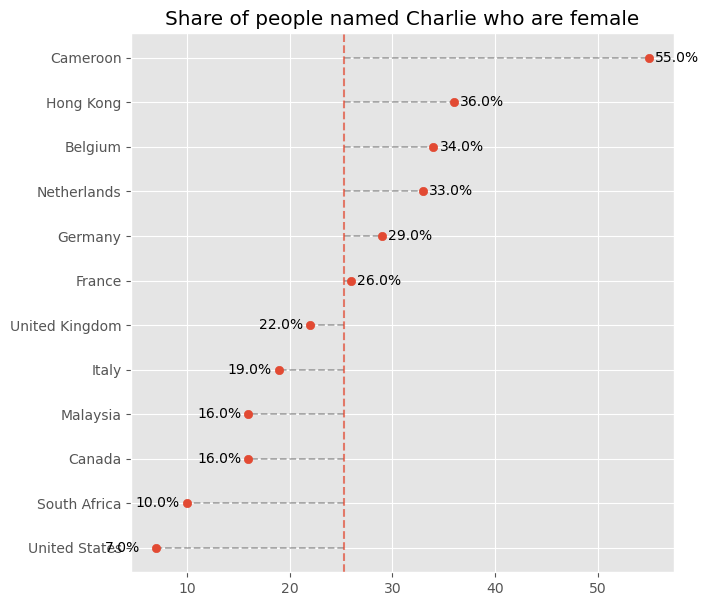

In [115]:
data = df[(df["name"] == "Charlie") & (df[["name","female"]].sum(axis=1) > 100)].sort_values("female_share").set_index("country")["female_share"]
with plt.style.context("ggplot"):
    plt.figure(figsize=(7,7))
    plt.scatter(data.values,data.index, zorder=20)
    plt.title("Share of people named Charlie who are female")
    
    mean = data.mean()
    plt.axvline(mean,alpha=0.7, linestyle="--")
    
    plt.hlines([i for i in range(len(data))], mean, data.values, alpha=0.3, linestyle="--", color="black", linewidth=1.3)
    
    for order,share in zip([i for i in range(len(data))],data.values):
        plt.text((share +0.6) if share > mean else (share -5),order,str(share) + "%", ha="left", va="center", fontsize=10)
    plt.show()

# Determining a name's likely origin

<font size="3"> Let's use the method we've used previously for surnames to assign an origin to a name.

In [121]:
def gini_coefficient(x):
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

df["count"] = df[["female","male"]].sum(axis=1)

#computing the country level name frequency, removing names that have a frequency lower than 0.0000005
df["freq"] = df["count"]/df.groupby("country")["count"].transform(sum)
df = df[df["freq"] > 0.0000005]

#computing the hhi
standardized_freq = df["freq"]/df.groupby("name")["freq"].transform(sum)
df["hhi"] = (standardized_freq**2).groupby(df['name']).transform(sum)
print("hhi done")

#computing the gini index
gini = df.groupby('name')["freq"].apply(np.array).apply(gini_coefficient)
df = df.merge(gini.rename("gini"),left_on="name",right_index=True)
print("gini done")

df["mean"] = df[["gini","hhi"]].mean(axis=1)
df

hhi done
gini done


,country,name,female,male,count,freq,hhi,gini,mean
0,Afghanistan,A,0.0,16.0,16.0,0.000110,0.055199,0.55375,0.304474
6725,Albania,A,5.0,7.0,12.0,0.000029,0.055199,0.55375,0.304474
17445,Algeria,A,16.0,50.0,66.0,0.000008,0.055199,0.55375,0.304474
157299,Angola,A,3.0,7.0,10.0,0.000059,0.055199,0.55375,0.304474
165233,Argentina,A,9.0,12.0,21.0,0.000010,0.055199,0.55375,0.304474
...,...,...,...,...,...,...,...,...,...
3750889,qatar,Ãb-DóÔò,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000
3750893,qatar,Ämģăď,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000
3750895,qatar,Éñámùl,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000
3750903,qatar,Ďayashankar,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000


<font size="3"> We can find a list of the frenchest names, that is, names that are most concentrated in France.

In [151]:
data = df.sort_values(["name","freq"],ascending=False).drop_duplicates("name")
data[ (data["count"] > 500) & (data["country"] == "France")].sort_values("mean",ascending=False)[["name","count"]][:30].reset_index(drop=True)

,name,count
0,Tiphaine,4393.0
1,Angélina,921.0
2,Erwann,1673.0
3,Rozenn,792.0
4,Nolwenn,3132.0
5,Enora,1441.0
6,Gwendal,1451.0
7,Chrystele,546.0
8,Solène,4706.0
9,Louloute,836.0


<font size="3"> For Ireland, the most typical names are of celtic origin :

In [155]:
data[ (data["count"] > 500) & (data["country"] == "Ireland")].sort_values("mean",ascending=False)[["name","count"]][:30].reset_index(drop=True)

,name,count
0,Aoife,5047.0
1,Eoin,3920.0
2,Brid,856.0
3,Aisling,3580.0
4,Colm,2910.0
5,Padraig,1674.0
6,Cian,2805.0
7,Cillian,718.0
8,Seán,1467.0
9,Dermot,1759.0


# Examples of applications

## Share of female names among top actors in french movies

I scraped all french movies since 2000 on the Allocine websites with the main actors and ratings.

In [3]:
files = glob("../data/first_names/fb_first_names/data/*.csv")
df_cine = pd.concat([pd.read_csv(i) for i in files])
df_cine["viewers"] = df_cine["viewers"].str.replace("Spectateurs\n","")
df_cine["actors"] = df_cine["actors"].str.strip("[]").str.replace(", ",",").str.split(",")
data = df_cine[["date","actors"]].explode("actors")
data["actors"] = data['actors'].str.strip("'")
data["date"] = data["date"].str.extract('([0-9]{4})')
data = data.dropna().reset_index(drop=True)
data['first_name'] = data['actors'].str.split().apply(lambda x : x[0]).str.strip().str.strip('"')
data

,date,actors,first_name
0,2002,Bruno Putzulu,Bruno
1,2002,Emmanuelle Grangé,Emmanuelle
2,2002,Emilie Lafarge,Emilie
3,2009,Bruno Todeschini,Bruno
4,2009,Natacha Régnier,Natacha
...,...,...,...
32081,2014,Laure Calamy,Laure
32082,2014,Jeanne Ferron,Jeanne
32083,2013,Orlando Bloom,Orlando
32084,2013,Forest Whitaker,Forest


In [4]:
df_fr = df[df["country"] == "France"]
data_fr = data.merge(df_fr,left_on="first_name",right_on="name",how="left")

data_other = data_fr[data_fr["name"].isna()][["date","actors","first_name"]]
df_other = df.groupby("name")["female","male"].sum().reset_index()

data_other = data_other.merge(df_other,left_on="first_name",right_on="name",how="left")
data_other.loc[data_other["first_name"].isin(["Golshifteh","Lorànt","Sagamore","Féodor","JoeyStarr","Gringe","Sotigui","Louis-Do","Kheiron"]),["name","male"]] = ["ok",1000]
data_other.loc[data_other["first_name"].isin(["Miou-Miou","Linh-Dan","Lilly-Fleur"]),["name","female"]] = ["ok",1000]

data_again = data_other[data_other["name"].isna()][["date","actors","first_name"]]
data_again["first_name"] = data_again["first_name"].apply(name_cleaner).str.split("-").apply(lambda x : x[0]).str.strip()
data_again = data_again.merge(df_other,left_on="first_name",right_on="name",how="left")

data = pd.concat([data_fr[data_fr["name"].notna()],data_other[data_other["name"].notna()],data_again])
data = data[data["name"].notna()]
data["gender"] = np.where(data["male"] > data["female"],"male","female")
data

<ipython-input-4-95b5a4518ebb>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_other = df.groupby("name")["female","male"].sum().reset_index()


,date,actors,first_name,country,name,female,male,gender
0,2002,Bruno Putzulu,Bruno,France,Bruno,322.0,46136.0,male
1,2002,Emmanuelle Grangé,Emmanuelle,France,Emmanuelle,14423.0,60.0,female
2,2002,Emilie Lafarge,Emilie,France,Emilie,36344.0,185.0,female
3,2009,Bruno Todeschini,Bruno,France,Bruno,322.0,46136.0,male
4,2009,Natacha Régnier,Natacha,France,Natacha,8418.0,51.0,female
...,...,...,...,...,...,...,...,...
394,2019,Luàna Bajrami,Luana,NaN,Luana,50475.0,513.0,female
397,2017,Jean-Stan du Pac,Jean,NaN,Jean,35455.0,111716.0,male
398,2013,Satô Kentarou,Sato,NaN,Sato,165.0,503.0,male
407,2020,Alain-Fabien Delon,Alain,NaN,Alain,947.0,92944.0,male


In [7]:
d = data.groupby(["date","gender"])["name"].count().unstack()
d["female_share"] = d["female"]/(d["female"] + d["male"])*100
d

gender,female,male,female_share
date,,,
2000,212,322,39.700375
2001,516,676,43.288591
2002,474,618,43.406593
2003,476,740,39.144737
2004,464,712,39.455782
2005,474,722,39.632107
2006,496,724,40.655738
2007,546,812,40.206186
2008,560,734,43.276662


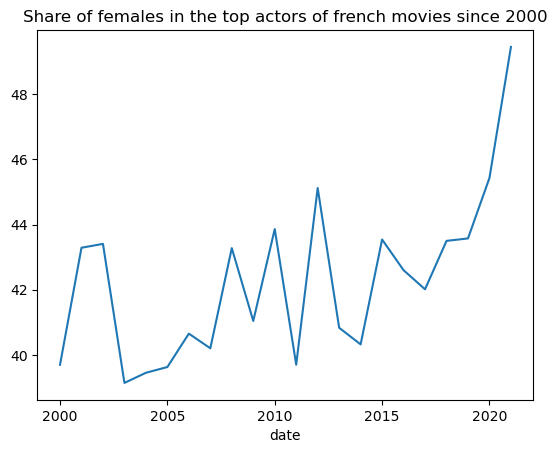

In [9]:
d["female_share"].plot()
plt.title("Share of females in the top actors of french movies since 2000")
plt.show()

## French president's schedule

<font size="3"> I scraped the schedule of Emmanuel Macron since 2017 and show the gender split of personnalities mentioned. Can we replicate it with only first name data?

In [10]:
data = pd.read_csv("/home/riri/Documents/projects/agenda président/agenda_président.csv")
name1 = data["description"].str.extract('( [A-Z]+),')[0]
name2 = data["description"].str.extract('( [A-Z]+ [A-Z]+),')[0]
data["name"] = np.where(name1.isna(),name2,name1)
data["name"] = np.where(data["description"].str.contains("CARRERE").fillna(False),"CARRERE d’ENCAUSSE",data["name"] )
data

,date,hour,event_type,description,program,name
0,2017-05-14,10:00,NaN,Passation de pouvoir et cérémonie d'investiture,"[""Discours d'investiture du président de la Ré...",NaN
1,2017-05-14,12:00,NaN,Cérémonie à l'hôtel de Ville de Paris,"[""Cérémonie à l'hôtel de Ville de Paris""]",NaN
2,2017-05-17,20:00,NaN,"Dîner avec M. Donald Tusk, Président du Consei...",[],NaN
3,2017-05-18,11:00,NaN,Conseil des ministres,"['Conseil des ministres', 'Photo de famille du...",NaN
4,2017-05-18,14:30,NaN,Conseil de défense,"['Conseil de défense', 'Conseil de défense']",NaN
...,...,...,...,...,...,...
2942,2021-11-24,16:00,Cérémonie officielle,Remise de décoration individuelle.,[],NaN
2943,2021-11-25,Matin,Voyage officiel,Visite officielle en République de Croatie.,['Partenariat stratégique franco-croate'],NaN
2944,2021-11-25,Après-midi,Déplacement,Déplacement en République italienne.,[],NaN
2945,2021-11-26,Matin,Déplacement,Déplacement en République italienne.,[],NaN


Extracting gender information

In [647]:
first_name1 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+) [A-Z]+,')[0]
first_name2 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+) [A-Z]+ [A-Z]+,')[0]
first_name1 = np.where(first_name1.isna(),first_name2,first_name1)

first_name3 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+\-[A-Z]{1}[a-zéçèïü]+) [A-Z]+,')[0]
first_name4 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+\-[A-Z]{1}[a-zéçèïü]+) [A-Z]+ [A-Z]+,')[0]
first_name2 = np.where(first_name3.isna(),first_name4,first_name3)


data["first_name"] = np.where(pd.Series(first_name1).isna(),first_name2,first_name1)


data.loc[data["description"].str.contains("RUGY"),'first_name'] = "François"
data.loc[data["description"].str.contains("CARRERE"),'first_name'] = "Hélène"
data.loc[data["description"].str.contains("LEYEN"),'first_name'] = "Ursula"
data.loc[data["description"].str.contains("VILLEROY de"),'first_name'] = "François"
data.loc[data["description"].str.contains("ROUX de"),'first_name'] = "Geoffroy"
#data = data["first_name"].str.strip().dropna()

Assigning a gender to the name.

In [651]:
data = df_other.merge(data,left_on="name",right_on="first_name", how="right")
data["male_share"] = (data["male"]/(data[["male","female"]].sum(axis=1)))

data.loc[(data["male_share"] < 0.8) & (data["male_share"] > 0.2),"gender"] = "epicene"
data.loc[data["male_share"] > 0.8,"gender"] = "Homme"
data.loc[data["male_share"] < 0.2,"gender"] = "Femme"

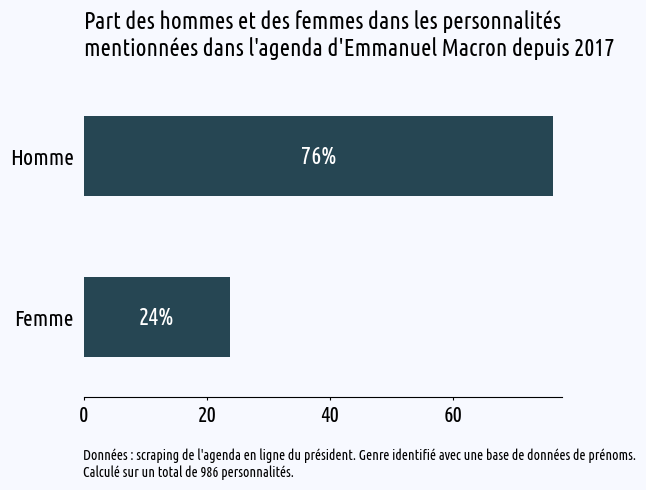

In [592]:
d = data[data["gender"] != "epicene"]["gender"].value_counts(normalize=True)*100
with plt.style.context("rirO"):
    plt.figure(figsize=(6.5,5))
    d.plot(kind='barh')
    plt.gca().invert_yaxis()
    for value, n in zip(d.values,[0,1]):
        plt.text(value/2,n,str(round(value,0))[:2] + "%", ha="center",color='white',fontsize=17,va="center")
        
    plt.title("Part des hommes et des femmes dans les personnalités\nmentionnées dans l'agenda d'Emmanuel Macron depuis 2017")
    
    plt.text(-0.07,2, "Données : scraping de l'agenda en ligne du président. Genre identifié avec une base de données de prénoms.\nCalculé sur un total de 986 personnalités.")
    
    plt.tight_layout()
    plt.savefig("macron_femmes.png",dpi=150)
    plt.show()

Same as what I found previously!